# importation
importation des bibliotheques qu'on va utiliser

In [112]:
import csv
from pymongo import MongoClient
import matplotlib.pyplot as plt

# Traitement sur le fichier de donnees
importation et conversion du contenu du fichier CSV en listes python

In [113]:
with open('../data/data.csv', encoding='utf-8-sig') as dataFile:
    reader = csv.reader(dataFile)
    data = []
    for row in reader:
        data.append(row)

    # pour supprimer la ligne des titres
    data.pop(0)
    print(data)

[['2005', 'Births', 'Northland region', '2067'], ['2005', 'Births', 'Auckland region', '20745'], ['2005', 'Births', 'Waikato region', '5667'], ['2005', 'Births', 'Bay of Plenty region', '3771'], ['2005', 'Births', 'Gisborne region', '777'], ['2005', 'Births', "Hawke's Bay region", '2115'], ['2005', 'Births', 'Taranaki region', '1410'], ['2005', 'Births', 'Manawatu-Wanganui region', '3093'], ['2005', 'Births', 'Wellington region', '6225'], ['2005', 'Births', 'Tasman region', '513'], ['2005', 'Births', 'Nelson region', '519'], ['2005', 'Births', 'Marlborough region', '471'], ['2005', 'Births', 'West Coast region', '336'], ['2005', 'Births', 'Canterbury region', '6603'], ['2005', 'Births', 'Otago region', '2151'], ['2005', 'Births', 'Southland region', '1212'], ['2005', 'Births', 'Region not stated or area outside region', '57'], ['2005', 'Births', 'New Zealand', '57747'], ['2005', 'Deaths', 'Northland region', '1167'], ['2005', 'Deaths', 'Auckland region', '6873'], ['2005', 'Deaths', 'Wa

# Filtrage
Filtrer le contenu de fichier et le diviser en 2 categories: `Births` et `Deaths`

In [114]:
birthsList = []
deathsList = []

for element in data:
    if element[1] == 'Births':
        birthsList.append({'year': element[0],
                           'region': element[2],
                           'count': element[3]
                           })
    else:
        deathsList.append({'year': element[0],
                           'region': element[2],
                           'count': int(element[3])
                           })

print(birthsList)

[{'year': '2005', 'region': 'Northland region', 'count': '2067'}, {'year': '2005', 'region': 'Auckland region', 'count': '20745'}, {'year': '2005', 'region': 'Waikato region', 'count': '5667'}, {'year': '2005', 'region': 'Bay of Plenty region', 'count': '3771'}, {'year': '2005', 'region': 'Gisborne region', 'count': '777'}, {'year': '2005', 'region': "Hawke's Bay region", 'count': '2115'}, {'year': '2005', 'region': 'Taranaki region', 'count': '1410'}, {'year': '2005', 'region': 'Manawatu-Wanganui region', 'count': '3093'}, {'year': '2005', 'region': 'Wellington region', 'count': '6225'}, {'year': '2005', 'region': 'Tasman region', 'count': '513'}, {'year': '2005', 'region': 'Nelson region', 'count': '519'}, {'year': '2005', 'region': 'Marlborough region', 'count': '471'}, {'year': '2005', 'region': 'West Coast region', 'count': '336'}, {'year': '2005', 'region': 'Canterbury region', 'count': '6603'}, {'year': '2005', 'region': 'Otago region', 'count': '2151'}, {'year': '2005', 'region

# Connexion avec mongodb

connexion et selection des collections `births` et `deaths`

In [115]:
client = MongoClient('mongodb://localhost:27017')

client.list_database_names()

DATABASE_NAME = 'births-and-deaths'
db = client[DATABASE_NAME]

births = db['births']
deaths = db['deaths']

births.delete_many({})
deaths.delete_many({})

births.insert_many(birthsList)
deaths.insert_many(deathsList)

# suppression des données inutilisées

In [116]:
births.delete_many({"region":"Region not stated or area outside region"})

# Aggregation:
selection des documents de la collection `births` qui ont comme annee `2021`

In [117]:
# births in 2021:
aggregation = [
    {
        '$match': {'year': '2021'},
    },
]
db.command('aggregate', 'births', pipeline=aggregation, explain=False)


{'cursor': {'firstBatch': [{'_id': ObjectId('6390c981a3fe584a9a209df3'),
    'year': '2021',
    'region': 'Northland region',
    'count': '2262'},
   {'_id': ObjectId('6390c981a3fe584a9a209df4'),
    'year': '2021',
    'region': 'Auckland region',
    'count': '20520'},
   {'_id': ObjectId('6390c981a3fe584a9a209df5'),
    'year': '2021',
    'region': 'Waikato region',
    'count': '6330'},
   {'_id': ObjectId('6390c981a3fe584a9a209df6'),
    'year': '2021',
    'region': 'Bay of Plenty region',
    'count': '4173'},
   {'_id': ObjectId('6390c981a3fe584a9a209df7'),
    'year': '2021',
    'region': 'Gisborne region',
    'count': '675'},
   {'_id': ObjectId('6390c981a3fe584a9a209df8'),
    'year': '2021',
    'region': "Hawke's Bay region",
    'count': '2127'},
   {'_id': ObjectId('6390c981a3fe584a9a209df9'),
    'year': '2021',
    'region': 'Taranaki region',
    'count': '1488'},
   {'_id': ObjectId('6390c981a3fe584a9a209dfa'),
    'year': '2021',
    'region': 'Manawatu-Wanganu

# afficher le contenu du 'births'

In [118]:
cursor = births.find()
for element in cursor:
    print(element)

{'_id': ObjectId('6390c981a3fe584a9a209cd3'), 'year': '2005', 'region': 'Northland region', 'count': '2067'}
{'_id': ObjectId('6390c981a3fe584a9a209cd4'), 'year': '2005', 'region': 'Auckland region', 'count': '20745'}
{'_id': ObjectId('6390c981a3fe584a9a209cd5'), 'year': '2005', 'region': 'Waikato region', 'count': '5667'}
{'_id': ObjectId('6390c981a3fe584a9a209cd6'), 'year': '2005', 'region': 'Bay of Plenty region', 'count': '3771'}
{'_id': ObjectId('6390c981a3fe584a9a209cd7'), 'year': '2005', 'region': 'Gisborne region', 'count': '777'}
{'_id': ObjectId('6390c981a3fe584a9a209cd8'), 'year': '2005', 'region': "Hawke's Bay region", 'count': '2115'}
{'_id': ObjectId('6390c981a3fe584a9a209cd9'), 'year': '2005', 'region': 'Taranaki region', 'count': '1410'}
{'_id': ObjectId('6390c981a3fe584a9a209cda'), 'year': '2005', 'region': 'Manawatu-Wanganui region', 'count': '3093'}
{'_id': ObjectId('6390c981a3fe584a9a209cdb'), 'year': '2005', 'region': 'Wellington region', 'count': '6225'}
{'_id': O

# Aggregation:
cette fonction python execute une commande d'aggregation de mongodb
pour trouver le nombre de décès ou naissances au cours d'une année donnée

In [119]:
def get_by_year(collection, year):
    aggregation_expression = [
        {
            '$match': {'year': str(year)},
        },
        {
            "$group": {"_id": "null", "somme": {"$sum": {"$toInt": "$count"}}}
        },
    ]

    ppl = db.command('aggregate', collection, pipeline=aggregation_expression, explain=False)
    # print("resultat d'aggregation \n", ppl, end='\n\n')
    try:
        # print(f"{collection} in {year}:")
        return ppl['cursor']['firstBatch'][0]['somme']
    except:
        return 0

print(get_by_year('deaths', 2008))
print(get_by_year('births', 2008))

58374
128622


[54063, 56484, 57042, 58374, 57924, 56871, 60165, 60195, 59136, 62127, 63216, 62361, 66687, 66456, 68523, 65220]
[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


<BarContainer object of 16 artists>

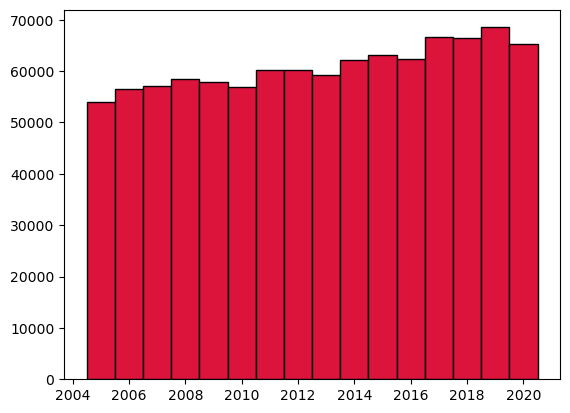

In [148]:
deaths_by_year = []
years = []

for x in range(2005,2021):
    years.append(x)
    deaths_by_year.append(get_by_year('deaths', str(x)))
print(deaths_by_year)
print(years)

plt.bar(years, deaths_by_year, width=1, color='crimson', ec='black')


[54063, 56484, 57042, 58374, 57924, 56871, 60165, 60195, 59136, 62127, 63216, 62361, 66687, 66456, 68523, 65220]
[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


<BarContainer object of 16 artists>

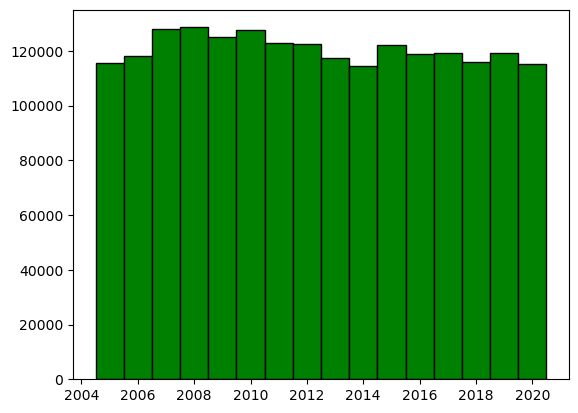

In [149]:
births_by_year = []
years = []

for x in range(2005,2021):
    years.append(x)
    births_by_year.append(get_by_year('births', str(x)))
print(deaths_by_year)
print(years)

plt.bar(years, births_by_year, width=1, color='green', ec='black')
